✓ Configuration loaded
  Sample Rate: 16000 Hz
  Clip Duration: 5.0 seconds
  Mel Bands: 128
  Output: /content/sunocaps_converted

STEP 1: Download SunoCaps Dataset from Kaggle

📦 Installing Kaggle API...

🔑 Setting up Kaggle credentials...

⚠️  IMPORTANT: You need to upload your kaggle.json file!
   1. Go to https://www.kaggle.com/settings
   2. Scroll to 'API' section
   3. Click 'Create New Token' to download kaggle.json
   4. Upload kaggle.json using the file upload button below

📤 Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
✓ Kaggle credentials configured

📥 Downloading SunoCaps dataset (this may take a few minutes)...
Dataset URL: https://www.kaggle.com/datasets/miguelcivit/sunocaps
License(s): CC-BY-SA-4.0
 98% 561M/575M [00:03<00:00, 80.4MB/s]
100% 575M/575M [00:03<00:00, 178MB/s] 

🔍 Locating dataset files...
✓ Dataset found at: /content/audio/audio

STEP 2: Scanning Audio Files

🔍 Scanning /content/audio/audio for audio files...
  Found 256 *.mp3 files

✓ Total audio files found: 256

STEP 3: Converting Audio to 5-Second Clips

🎵 Processing 256 audio files...
   This will take some time...



Converting audio:   0%|          | 0/256 [00:00<?, ?it/s]


✓ Audio conversion complete!
  Original files: 256
  Total 5-second clips created: 4956
  Failed files: 0

STEP 4: Extracting Mel-Spectrograms

🔬 Extracting spectrograms from 4956 clips...


Extracting spectrograms:   0%|          | 0/4956 [00:00<?, ?it/s]


✓ Spectrogram extraction complete!
  Successfully extracted: 4956
  Failed: 0
  Spectrogram shape: (4956, 128, 157)
  Expected shape: (4956, 128, ~157)

STEP 5: Saving Converted Dataset

💾 Saving spectrograms...

✓ Dataset saved successfully!

  Output location: /content/sunocaps_converted/
  Files created:
    - sunocaps_spectrograms.npz (316.2 MB)
    - metadata.json
    - audio_clips/ (4956 WAV files)

STEP 6: Visualization

📊 Creating sample visualizations...


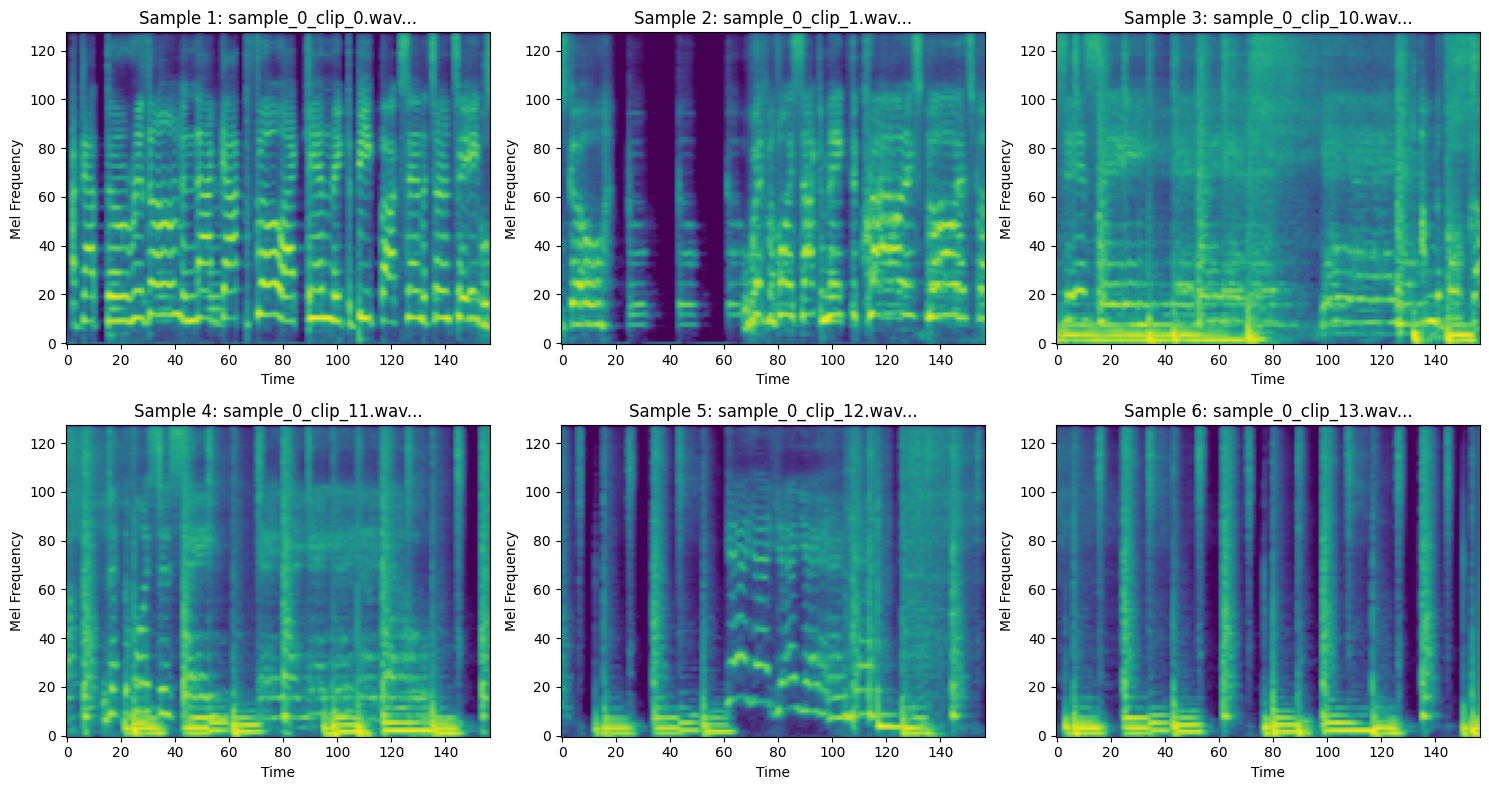

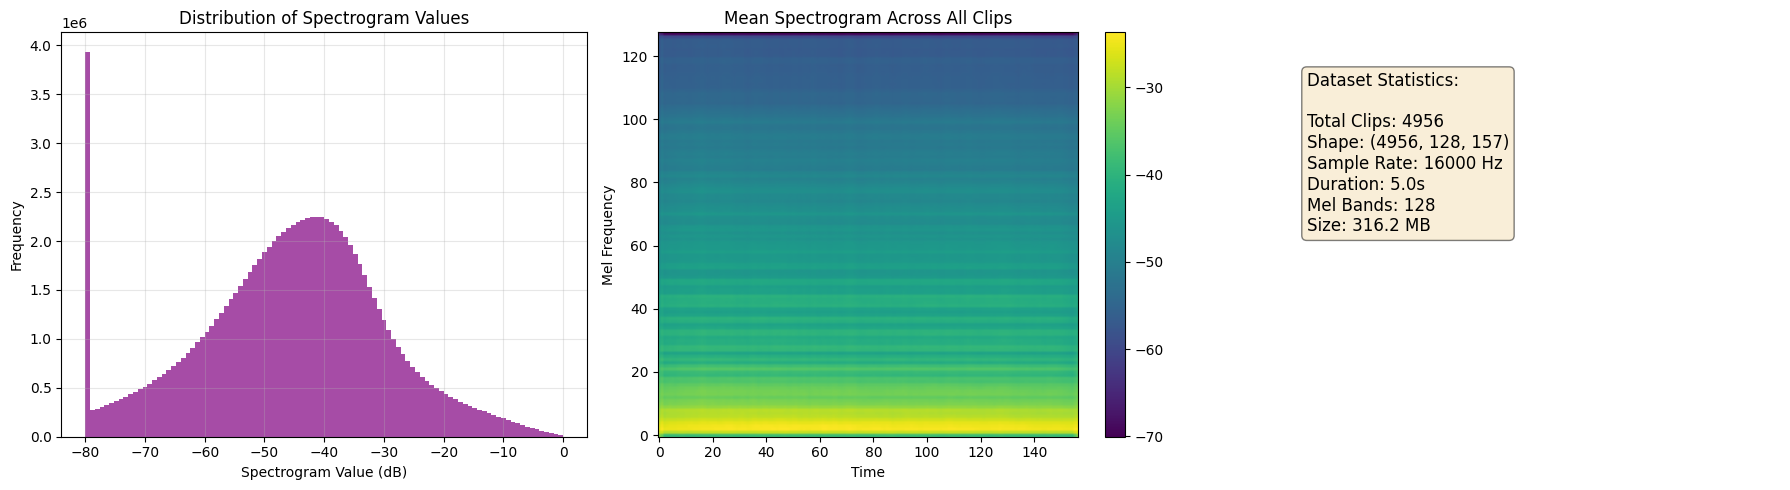

✓ Visualizations saved

CONVERSION COMPLETE! 🎉

📦 Converted Dataset Summary:
  Location: /content/sunocaps_converted/
  Original files: 256
  5-second clips: 4956
  Spectrograms: 4956
  Format: (4956, 128, 157)

📝 Usage Instructions:

# Load SunoCaps spectrograms in your training notebook:
data = np.load('/content/sunocaps_converted/sunocaps_spectrograms.npz')
sunocaps_spectrograms = data['spectrograms']
sunocaps_filenames = data['filenames']

# All are AI-generated (label = 1)
sunocaps_labels = np.ones(len(sunocaps_spectrograms), dtype=np.int64)

print(f"Loaded {len(sunocaps_spectrograms)} SunoCaps samples")
print(f"Shape: {sunocaps_spectrograms.shape}")


📥 Download the converted dataset:

📦 Creating download package...
✓ Package created



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Dataset is ready for testing with your trained model!

Generated files:
  ✓ /content/sunocaps_converted/sunocaps_spectrograms.npz
  ✓ /content/sunocaps_converted/metadata.json
  ✓ /content/sunocaps_converted/sample_spectrograms.png
  ✓ /content/sunocaps_converted/statistics.png
  ✓ /content/sunocaps_converted/audio_clips/ (individual WAV files)


In [1]:
# ============================================================================
# SunoCaps Dataset Converter for Synthetic Music Detection
# Downloads from Kaggle and converts to 5-second clips with mel-spectrograms
# ============================================================================

import os
import json
import numpy as np
import librosa
import soundfile as sf
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import zipfile

# ============================================================================
# CONFIGURATION
# ============================================================================

# Output directory
OUTPUT_BASE_DIR = '/content/sunocaps_converted'
OUTPUT_AUDIO_DIR = f"{OUTPUT_BASE_DIR}/audio_clips"
OUTPUT_SPECTROGRAMS_DIR = f"{OUTPUT_BASE_DIR}/spectrograms"

# Audio Processing Parameters (MUST match training configuration)
SAMPLE_RATE = 16000        # 16kHz
DURATION = 5.0             # 5 seconds
N_MELS = 128               # 128 mel bands
N_FFT = 2048               # FFT window
HOP_LENGTH = 512           # Hop length

# Create output directories
os.makedirs(OUTPUT_AUDIO_DIR, exist_ok=True)
os.makedirs(OUTPUT_SPECTROGRAMS_DIR, exist_ok=True)

print(f"✓ Configuration loaded")
print(f"  Sample Rate: {SAMPLE_RATE} Hz")
print(f"  Clip Duration: {DURATION} seconds")
print(f"  Mel Bands: {N_MELS}")
print(f"  Output: {OUTPUT_BASE_DIR}")

# ============================================================================
# STEP 1: Setup Kaggle API and Download Dataset
# ============================================================================

print("\n" + "="*80)
print("STEP 1: Download SunoCaps Dataset from Kaggle")
print("="*80)

# Install kaggle API
print("\n📦 Installing Kaggle API...")
!pip install -q kaggle

# Setup Kaggle credentials
print("\n🔑 Setting up Kaggle credentials...")
print("\n⚠️  IMPORTANT: You need to upload your kaggle.json file!")
print("   1. Go to https://www.kaggle.com/settings")
print("   2. Scroll to 'API' section")
print("   3. Click 'Create New Token' to download kaggle.json")
print("   4. Upload kaggle.json using the file upload button below\n")

# Upload kaggle.json
from google.colab import files
print("📤 Please upload your kaggle.json file:")
uploaded = files.upload()

# Setup kaggle directory and credentials
os.makedirs('/root/.kaggle', exist_ok=True)
if 'kaggle.json' in uploaded:
    with open('/root/.kaggle/kaggle.json', 'w') as f:
        f.write(uploaded['kaggle.json'].decode())
    os.chmod('/root/.kaggle/kaggle.json', 600)
    print("✓ Kaggle credentials configured")
else:
    print("❌ kaggle.json not uploaded. Please try again.")
    raise Exception("Kaggle credentials required")

# Download dataset directly from Kaggle
print("\n📥 Downloading SunoCaps dataset (this may take a few minutes)...")
!kaggle datasets download -d miguelcivit/sunocaps -p /content --unzip

# Find the extracted directory
print("\n🔍 Locating dataset files...")
SUNOCAPS_INPUT_DIR = None
for possible_dir in ['/content/sunocaps', '/content/SunoCaps', '/content/dataset']:
    if os.path.exists(possible_dir):
        SUNOCAPS_INPUT_DIR = possible_dir
        break

# If not found, search for any directory with audio files
if SUNOCAPS_INPUT_DIR is None:
    for root, dirs, files in os.walk('/content'):
        if any(f.endswith(('.mp3', '.wav', '.flac', '.ogg')) for f in files):
            SUNOCAPS_INPUT_DIR = root
            break

if SUNOCAPS_INPUT_DIR is None:
    print("❌ Could not locate SunoCaps dataset!")
    print("   Please check the extraction manually")
    raise Exception("Dataset not found")

print(f"✓ Dataset found at: {SUNOCAPS_INPUT_DIR}")

# ============================================================================
# STEP 2: Find All Audio Files
# ============================================================================

print("\n" + "="*80)
print("STEP 2: Scanning Audio Files")
print("="*80)

print(f"\n🔍 Scanning {SUNOCAPS_INPUT_DIR} for audio files...")

audio_extensions = ['*.mp3', '*.wav', '*.flac', '*.ogg', '*.m4a']
all_audio_files = []

for ext in audio_extensions:
    files_found = list(Path(SUNOCAPS_INPUT_DIR).rglob(ext))
    all_audio_files.extend(files_found)
    if files_found:
        print(f"  Found {len(files_found)} {ext} files")

print(f"\n✓ Total audio files found: {len(all_audio_files)}")

if len(all_audio_files) == 0:
    print("\n❌ No audio files found!")
    print(f"   Directory contents: {os.listdir(SUNOCAPS_INPUT_DIR)}")
    raise Exception("No audio files detected")

# ============================================================================
# STEP 3: Process Audio Files
# ============================================================================

print("\n" + "="*80)
print("STEP 3: Converting Audio to 5-Second Clips")
print("="*80)

def process_audio_file(audio_path, output_dir, file_index):
    """
    Process variable-length audio into 5-second clips.
    Returns number of clips created.
    """
    try:
        # Load audio at target sample rate
        audio, sr = librosa.load(audio_path, sr=SAMPLE_RATE)

        # Calculate clip length in samples
        clip_length = int(SAMPLE_RATE * DURATION)

        # Calculate number of clips
        n_clips = len(audio) // clip_length

        clips_created = 0

        if n_clips == 0:
            # Audio shorter than 5 seconds - pad it
            audio_padded = np.pad(audio, (0, clip_length - len(audio)), mode='constant')

            # Save audio clip
            output_path = f"{output_dir}/sample_{file_index}_clip_0.wav"
            sf.write(output_path, audio_padded, SAMPLE_RATE)
            clips_created = 1

        else:
            # Extract multiple non-overlapping clips
            for clip_idx in range(n_clips):
                start = clip_idx * clip_length
                end = start + clip_length
                clip = audio[start:end]

                # Save audio clip
                output_path = f"{output_dir}/sample_{file_index}_clip_{clip_idx}.wav"
                sf.write(output_path, clip, SAMPLE_RATE)
                clips_created += 1

        return clips_created, True

    except Exception as e:
        print(f"  Error: {audio_path.name} - {str(e)}")
        return 0, False

# Process all audio files
print(f"\n🎵 Processing {len(all_audio_files)} audio files...")
print("   This will take some time...\n")

total_clips = 0
failed_files = []

for idx, audio_file in enumerate(tqdm(all_audio_files, desc="Converting audio")):
    n_clips, success = process_audio_file(audio_file, OUTPUT_AUDIO_DIR, idx)

    if success:
        total_clips += n_clips
    else:
        failed_files.append(str(audio_file))

print(f"\n✓ Audio conversion complete!")
print(f"  Original files: {len(all_audio_files)}")
print(f"  Total 5-second clips created: {total_clips}")
print(f"  Failed files: {len(failed_files)}")

# ============================================================================
# STEP 4: Extract Mel-Spectrograms
# ============================================================================

print("\n" + "="*80)
print("STEP 4: Extracting Mel-Spectrograms")
print("="*80)

def extract_mel_spectrogram(audio_path):
    """Extract mel-spectrogram from audio file."""
    try:
        # Load audio
        audio, sr = librosa.load(audio_path, sr=SAMPLE_RATE)

        # Extract mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=audio,
            sr=SAMPLE_RATE,
            n_mels=N_MELS,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH
        )

        # Convert to log scale (dB)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        return mel_spec_db, True

    except Exception as e:
        return None, False

# Get all converted audio clips
converted_clips = sorted(list(Path(OUTPUT_AUDIO_DIR).glob("*.wav")))

print(f"\n🔬 Extracting spectrograms from {len(converted_clips)} clips...")

spectrograms = []
spectrogram_files = []
failed_spectrograms = []

for clip_path in tqdm(converted_clips, desc="Extracting spectrograms"):
    mel_spec, success = extract_mel_spectrogram(clip_path)

    if success:
        spectrograms.append(mel_spec)
        spectrogram_files.append(clip_path.name)
    else:
        failed_spectrograms.append(str(clip_path))

# Convert to numpy array
spectrograms = np.array(spectrograms, dtype=np.float32)

print(f"\n✓ Spectrogram extraction complete!")
print(f"  Successfully extracted: {len(spectrograms)}")
print(f"  Failed: {len(failed_spectrograms)}")
print(f"  Spectrogram shape: {spectrograms.shape}")
print(f"  Expected shape: ({len(spectrograms)}, {N_MELS}, ~{int(SAMPLE_RATE * DURATION / HOP_LENGTH) + 1})")

# ============================================================================
# STEP 5: Save Converted Dataset
# ============================================================================

print("\n" + "="*80)
print("STEP 5: Saving Converted Dataset")
print("="*80)

# Save spectrograms as compressed numpy array
print("\n💾 Saving spectrograms...")
np.savez_compressed(
    f"{OUTPUT_BASE_DIR}/sunocaps_spectrograms.npz",
    spectrograms=spectrograms,
    filenames=np.array(spectrogram_files)
)

# Save metadata
metadata = {
    'dataset_name': 'SunoCaps (Converted)',
    'source_url': 'https://www.kaggle.com/datasets/miguelcivit/sunocaps',
    'total_original_files': len(all_audio_files),
    'total_clips': len(spectrograms),
    'sample_rate': SAMPLE_RATE,
    'duration': DURATION,
    'n_mels': N_MELS,
    'n_fft': N_FFT,
    'hop_length': HOP_LENGTH,
    'spectrogram_shape': list(spectrograms.shape),
    'failed_conversions': len(failed_files),
    'failed_spectrograms': len(failed_spectrograms),
    'label': 'ai_generated',  # All SunoCaps files are AI-generated
    'source': 'Suno AI',
    'processing_date': str(np.datetime64('today'))
}

with open(f"{OUTPUT_BASE_DIR}/metadata.json", 'w') as f:
    json.dump(metadata, f, indent=2)

# Calculate file sizes
spectrograms_size = os.path.getsize(f"{OUTPUT_BASE_DIR}/sunocaps_spectrograms.npz") / 1024**2

print(f"\n✓ Dataset saved successfully!")
print(f"\n  Output location: {OUTPUT_BASE_DIR}/")
print(f"  Files created:")
print(f"    - sunocaps_spectrograms.npz ({spectrograms_size:.1f} MB)")
print(f"    - metadata.json")
print(f"    - audio_clips/ ({total_clips} WAV files)")

# ============================================================================
# STEP 6: Visualize Sample Spectrograms
# ============================================================================

print("\n" + "="*80)
print("STEP 6: Visualization")
print("="*80)

print("\n📊 Creating sample visualizations...")

# Plot sample spectrograms
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i in range(6):
    if i < len(spectrograms):
        axes[i].imshow(spectrograms[i], aspect='auto', origin='lower', cmap='viridis')
        axes[i].set_title(f'Sample {i+1}: {spectrogram_files[i][:30]}...')
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Mel Frequency')

plt.tight_layout()
plt.savefig(f"{OUTPUT_BASE_DIR}/sample_spectrograms.png", dpi=150, bbox_inches='tight')
plt.show()

# Plot statistics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Distribution of spectrogram values
axes[0].hist(spectrograms.flatten(), bins=100, alpha=0.7, color='purple')
axes[0].set_xlabel('Spectrogram Value (dB)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Spectrogram Values')
axes[0].grid(True, alpha=0.3)

# Plot 2: Mean spectrogram
mean_spec = spectrograms.mean(axis=0)
im = axes[1].imshow(mean_spec, aspect='auto', origin='lower', cmap='viridis')
axes[1].set_title('Mean Spectrogram Across All Clips')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Mel Frequency')
plt.colorbar(im, ax=axes[1])

# Plot 3: Shape information
axes[2].text(0.1, 0.7, f'Dataset Statistics:\n\n'
             f'Total Clips: {len(spectrograms)}\n'
             f'Shape: {spectrograms.shape}\n'
             f'Sample Rate: {SAMPLE_RATE} Hz\n'
             f'Duration: {DURATION}s\n'
             f'Mel Bands: {N_MELS}\n'
             f'Size: {spectrograms_size:.1f} MB',
             fontsize=12, verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[2].axis('off')

plt.tight_layout()
plt.savefig(f"{OUTPUT_BASE_DIR}/statistics.png", dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved")

# ============================================================================
# STEP 7: Download Results
# ============================================================================

print("\n" + "="*80)
print("CONVERSION COMPLETE! 🎉")
print("="*80)

print(f"\n📦 Converted Dataset Summary:")
print(f"  Location: {OUTPUT_BASE_DIR}/")
print(f"  Original files: {len(all_audio_files)}")
print(f"  5-second clips: {total_clips}")
print(f"  Spectrograms: {len(spectrograms)}")
print(f"  Format: {spectrograms.shape}")

print(f"\n📝 Usage Instructions:")
print(f"""
# Load SunoCaps spectrograms in your training notebook:
data = np.load('/content/sunocaps_converted/sunocaps_spectrograms.npz')
sunocaps_spectrograms = data['spectrograms']
sunocaps_filenames = data['filenames']

# All are AI-generated (label = 1)
sunocaps_labels = np.ones(len(sunocaps_spectrograms), dtype=np.int64)

print(f"Loaded {{len(sunocaps_spectrograms)}} SunoCaps samples")
print(f"Shape: {{sunocaps_spectrograms.shape}}")
""")

print(f"\n📥 Download the converted dataset:")
from google.colab import files

# Zip the main file for easier download
print("\n📦 Creating download package...")
!zip -q {OUTPUT_BASE_DIR}/sunocaps_converted.zip {OUTPUT_BASE_DIR}/sunocaps_spectrograms.npz {OUTPUT_BASE_DIR}/metadata.json {OUTPUT_BASE_DIR}/*.png

print("✓ Package created")
print("\nDownloading main files...")
files.download(f"{OUTPUT_BASE_DIR}/sunocaps_spectrograms.npz")
files.download(f"{OUTPUT_BASE_DIR}/metadata.json")

print(f"\n✅ Dataset is ready for testing with your trained model!")
print(f"\nGenerated files:")
print(f"  ✓ {OUTPUT_BASE_DIR}/sunocaps_spectrograms.npz")
print(f"  ✓ {OUTPUT_BASE_DIR}/metadata.json")
print(f"  ✓ {OUTPUT_BASE_DIR}/sample_spectrograms.png")
print(f"  ✓ {OUTPUT_BASE_DIR}/statistics.png")
print(f"  ✓ {OUTPUT_BASE_DIR}/audio_clips/ (individual WAV files)")